## Notes
- Thinking of making batch size large and just use the batch as the set of images to cluster
- If want to go for variable dataset sizes, can just have an outer loop that will change the batch size but train the same model

## Bugs
- MLPs are not training!!!

## Combinations
- {lr: 0.0001, N: 200, niter: 20, n_iter: 300} 

### Import Packages

In [1]:
from pointnet import PointNet
from permnet import PermNet

import numpy as np
import time

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam, AdamW
from pyro.nn import PyroModule

import torch
import torch.nn as nn
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tabulate import tabulate

### Load Data

In [2]:
# from https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5), (.5))
        ])
    out_dir = './data/mnist'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [3]:
# Load data
N = 50
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=N, shuffle=True)
# Num batches
num_batches = len(data_loader)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Pyro

In [4]:
def model(data, step, assignment_list):
    # global variables
    alpha = torch.ones(T)
    weights = pyro.sample('weights', Dirichlet(alpha))
    
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(torch.zeros(M), torch.eye(M)))

    # use PCA to reduce dimensionality so I can train faster
    img_set = images_to_vectors(data.squeeze())
    (U, S, V) = torch.pca_lowrank(img_set, q=None, center=True, niter=20)
    z = torch.matmul(data, V[:, :100000])
    # local variables
    with pyro.plate('data', N):
        assignment = pyro.sample('assignments', Categorical(weights))
        pyro.sample('obs', MultivariateNormal(locs[assignment], torch.eye(M)), obs=z)
        
def guide(data, step, assignment_list):
    # train nn if doing offline training
    if not amortize:
        pyro.module('alpha_mlp', alpha_mlp)
        pyro.module('tau_mlp', tau_mlp)
    
    if use_gpu: 
        data = data.cuda()
        
    tau = tau_mlp(data.float())
    tau = tau.view(T,M)

    # sample mixture components mu
    with pyro.plate('components', T):
        locs = pyro.sample('locs', MultivariateNormal(tau, torch.eye(M)))
    
    # sample cluster assignments
    alpha = alpha_mlp(data.float()) # returns a vector of length T
    weights = pyro.sample('weights', Dirichlet(alpha))  # vector of length T
    with pyro.plate('data', size=N):
        assignments = pyro.sample('assignments', Categorical(weights))
    
    # logging
    if step % log_iter == 0:
        
        print('='*10, 'Iteration {}'.format(step), '='*10)
        assignment_list.append(assignments)
        
        weight_data = [weights.squeeze()[i] for i in range(len(weights.squeeze()))]
        weight_data.insert(0, 'props')

        pc1_data = [locs[i,0] for i in range(locs.shape[0])]
        pc1_data.insert(0, 'pc1')

        pc2_data = [locs[i,1] for i in range(locs.shape[0])]
        pc2_data.insert(0, 'pc2')
        
        pc3_data = [locs[i,2] for i in range(locs.shape[0])]
        pc3_data.insert(0, 'pc3')
        
        pc4_data = [locs[i,3] for i in range(locs.shape[0])]
        pc4_data.insert(0, 'pc4')
        
        pc5_data = [locs[i,4] for i in range(locs.shape[0])]
        pc5_data.insert(0, 'pc5')
        
        pc6_data = [locs[i,5] for i in range(locs.shape[0])]
        pc6_data.insert(0, 'pc6')
        
        
        data = [weight_data, pc1_data, pc2_data, pc3_data, pc4_data, pc5_data, pc6_data]
        
        print(tabulate(data, headers=['', 'clust1', 'clust2', 'clust3', 'clust4', 'clust5', 'clust6', 'clust7', 'clust8', 'clust9', 'clust10']))

### Initialization

In [5]:
T = 10  # num components
M = 6  # how many features after pca

mlp_type = 'pointnet'
amortize = False

if mlp_type == 'pointnet':
    alpha_mlp = PointNet(in_ch=784, output_size=T).float() 
    tau_mlp = PointNet(in_ch=784, output_size=T*M, softmax=False).float()
if mlp_type == 'permnet':
    alpha_mlp = PermNet(in_ch=784, hidden=2048, output_size=T).float()
    tau_mlp = PermNet(in_ch=784, hidden=2048, output_size=T*M).float()
if mlp_type == 'convnet':
    alpha_mlp = PermNet(in_ch=784, hidden=2048, output_size=T).float()
    tau_mlp = PermNet(in_ch=784, hidden=2048, output_size=T*M).float()
    
    
if amortize:
    saved_alpha_mlp = torch.load('saved_models/{}/mnist_alpha_mlp.pth'.format(mlp_type))
    saved_tau_mlp = torch.load('saved_models/{}/mnist_tau_mlp.pth'.format(mlp_type))
    
    alpha_mlp.load_state_dict(saved_alpha_mlp['model_state_dict'])
    tau_mlp.load_state_dict(saved_tau_mlp['model_state_dict'])

adam_params = {"lr": 0.0001}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('using GPU!')
    alpha_mlp = alpha_mlp.cuda()
    tau_mlp = tau_mlp.cuda()
else:
    print('not using GPU!')

not using GPU!


/home/kyang/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Training

tensor([1, 8, 3, 1, 9, 6, 0, 4, 2, 7, 4, 0, 8, 7, 4, 6, 8, 6, 3, 1, 1, 4, 3, 1,
        0, 1, 3, 8, 0, 0, 5, 4, 8, 8, 1, 0, 2, 3, 8, 0, 0, 5, 0, 0, 5, 8, 8, 7,
        9, 2])
========== Iteration 0 ==========
             clust1       clust2      clust3        clust4        clust5        clust6       clust7      clust8        clust9       clust10
-----  ------------  -----------  ----------  ------------  ------------  ------------  -----------  ----------  ------------  ------------
props   0.000264742   0.00129388   0.980851    1.25055e-11   4.64749e-06   1.72937e-16   0.00486761   0.0115968   0.000267309   0.000854048
pc1    -1.36237      -0.631705     0.394668    2.69146      -0.696804      0.317426      0.747102     1.15833    -0.171725      1.46997
pc2    -1.13084      -0.314129     0.0857206   0.33743       1.65139      -0.382053      0.0732405    0.0978217  -1.55174      -0.241373
pc3     1.21736      -0.633853    -0.448727   -0.543461      1.24484       0.256745      0.296193 

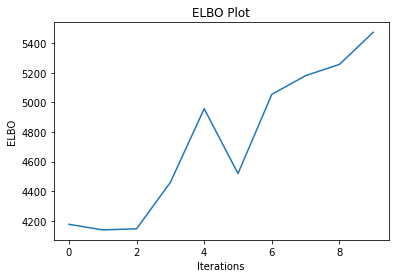

In [6]:
epochs = 20
dry = False
log_iter = 10

for epoch in range(epochs):
    for n_batch, (real_batch, labels) in enumerate(data_loader):
        print(labels)
        data = images_to_vectors(real_batch).unsqueeze(0)
        assignment_list = []
        elbo_ests = []
        n_steps = 10
        start = time.time()
        
        for step in range(n_steps):
            elbo_est = svi.step(data, step, assignment_list)
            elbo_ests.append(elbo_est)
            if step % log_iter == 0:
                end = time.time()
                print('took', end-start, 'seconds')
                start = time.time()
        
        if not dry:
            torch.save({'model_state_dict': alpha_mlp.state_dict(),
                        'assignments': assignment_list[-1],
                        'elbo_ests': elbo_ests,
                        'steps': n_steps,
                        'images': data,
                        'labels': labels
                       }, 'saved_models/{0}/mnist_alpha_mlp_{1}.pth'.format(mlp_type, n_steps))

            torch.save({'model_state_dict': tau_mlp.state_dict(),
                        'assignments': assignment_list[-1],
                        'elbo_ests': elbo_ests,
                        'steps': n_steps,
                        'images': data,
                        'labels': labels
                       }, 'saved_models/{0}/mnist_tau_mlp_{1}.pth'.format(mlp_type, n_steps))
        
        plt.plot(np.array(elbo_ests))
        plt.title('ELBO Plot')
        plt.xlabel('Iterations')
        plt.ylabel('ELBO')
        plt.savefig('figs/elbo_plot_mnist_{0}_{1}.png'.format(mlp_type, n_steps))
        break
    break